#  作業

Hint: 人物原始邊框座標 (60, 40), (420, 510)

請根據 Lena 圖做以下處理

- 對明亮度做直方圖均衡處理
- 水平鏡像 + 縮放處理 (0.5 倍)
- 畫出人物矩形邊框

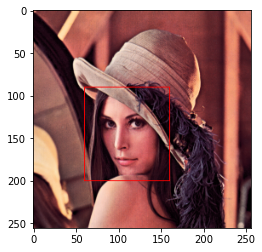

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt  
img = cv2.imread('data/lena.png')
# RGB to HSV
img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
# 對明亮度做直方均值
img_hsv[...,-1] = cv2.equalizeHist(img_hsv[...,-1])
#HSV to RGB
img_rgb = cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB)
#影像鏡射
img_rgb = img_rgb[:,::-1,:]
#使用比例縮放  (fx  fy )
img_rgb = cv2.resize(img_rgb, None ,fx = 0.5, fy = 0.5, 
interpolation=cv2.INTER_LINEAR)
# 矩形標記
cv2.rectangle(img_rgb,(60,90),(160,200),(0,0,255))

plt.imshow(img_rgb[:,:,::-1])
plt.show()

## Hint: 矩形

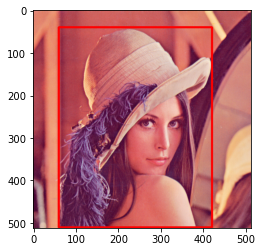

In [6]:
img_rect = img.copy()
cv2.rectangle(img_rect, (60, 40), (420, 510), (0, 0, 255), 3)

plt.imshow(img_rect[:,:,::-1])
plt.show()

## Hint: 線

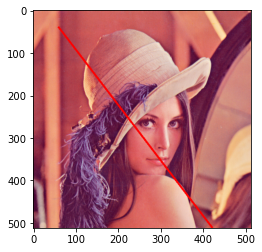

In [7]:
img_line = img.copy()
cv2.line(img_line, (60, 40), (420, 510), (0, 0, 255), 3)

plt.imshow(img_line[:,:,::-1])
plt.show()

## Hint: 文字

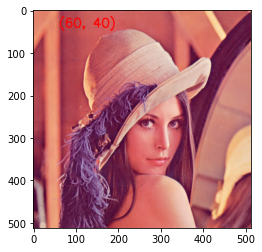

In [8]:
img_text = img.copy()
cv2.putText(img_text, '(60, 40)', (60, 40), 0, 1, (0, 0, 255), 2)

plt.imshow(img_text[:,:,::-1])
plt.show()

##  解法二

如果希望得知矩型邊框的位置

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 鏡像可以透過四則運算得知
3. 透過建構 transformation matrix 做縮放
4. 把矩型邊框的點與 transformation matrix 相乘就會得到縮放後的位置
5. 畫圖

得到的圖的結果正確，同時也知道新的矩型邊框座標點

origin point1=[92, 40], origin point2=[452, 510]
resize point1=(46, 20), resize point2=(226, 255)


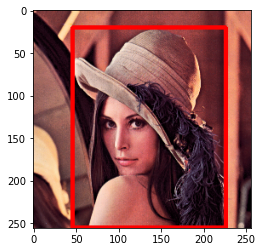

In [88]:
img_hw = img.copy()
point1 = [60, 40]
point2 = [420, 510]

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[...,-1] = cv2.equalizeHist(img_hw[...,-1])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2BGR)

"""
水平鏡像
"""
h, w = img_hw.shape[:2]

# 圖片鏡像
img_hw = img_hw[:,::-1,:]

# 透過四則運算計算鏡像後位置
# 確保點的位置一樣是左上跟右下，所以交換鏡像後的 x 座標 (y 座標做水平鏡像後位置不變)
point1[0] = w-point1[0]
point2[0] = w-point2[0]
point1[0],point2[0] = point2[0] ,point1[0]
"""
縮放處理 (0.5 倍)
"""
fx = 0.5
fy = 0.5
resize_col = int(img_hw.shape[1]*fx)
resize_row = int(img_hw.shape[0]*fy)

# 建構 scale matrix
M_scale = np.float32([[0.5,0,0],[0,0.5,0]])
img_hw = cv2.warpAffine(img_hw,M_scale,(resize_col,resize_row))

# 把左上跟右下轉為矩陣型式
bbox = np.array((point1, point2), dtype=np.float32)
#print('M_scale.shape={}, bbox.shape={}'.format(M_scale.shape, bbox.shape))

# 做矩陣乘法可以使用 `np.dot`, 為了做矩陣乘法, M_scale 需要做轉置之後才能相乘
homo_coor_result = np.dot(M_scale.T, bbox)
homo_coor_result = homo_coor_result.astype('uint8')
#print(homo_coor_result)
scale_point1 = tuple(homo_coor_result[0])
scale_point2 = tuple(homo_coor_result[1])
print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

# 畫圖
cv2.rectangle(img_hw, scale_point1, scale_point2, (0, 0, 255), 3)
plt.imshow(img_hw[:,:,::-1])
plt.show()

##  解法三 (optional)

把矩型邊框用遮罩的方式呈現，使用同樣處理圖片的方式處理遮罩
最後再找遮罩的左上跟右下的點的位置

這邊會用到許多沒提過的東西，所以當作 optional

In [98]:
img_hw = img.copy()

# 2D mask
img_mask = np.zeros_like(img_hw)
img_mask[40:510, 60:420, ...] = 255


# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)


# 圖片、mask 鏡像
img_hw = img_hw[:,::-1,:]
img_mask = img_mask[:,::-1,:]

# 縮放處理
img_hw = cv2.resize(img_hw, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
img_mask = cv2.resize(img_mask, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

#取得座標
all_h_coor, all_w_coor, all_c_coor = np.where(img_mask)

scale_point1 = (min(all_w_coor), min(all_h_coor))
scale_point2 = (max(all_w_coor), max(all_h_coor))

print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

origin point1=[92, 40], origin point2=[452, 510]
resize point1=(46, 20), resize point2=(225, 254)
